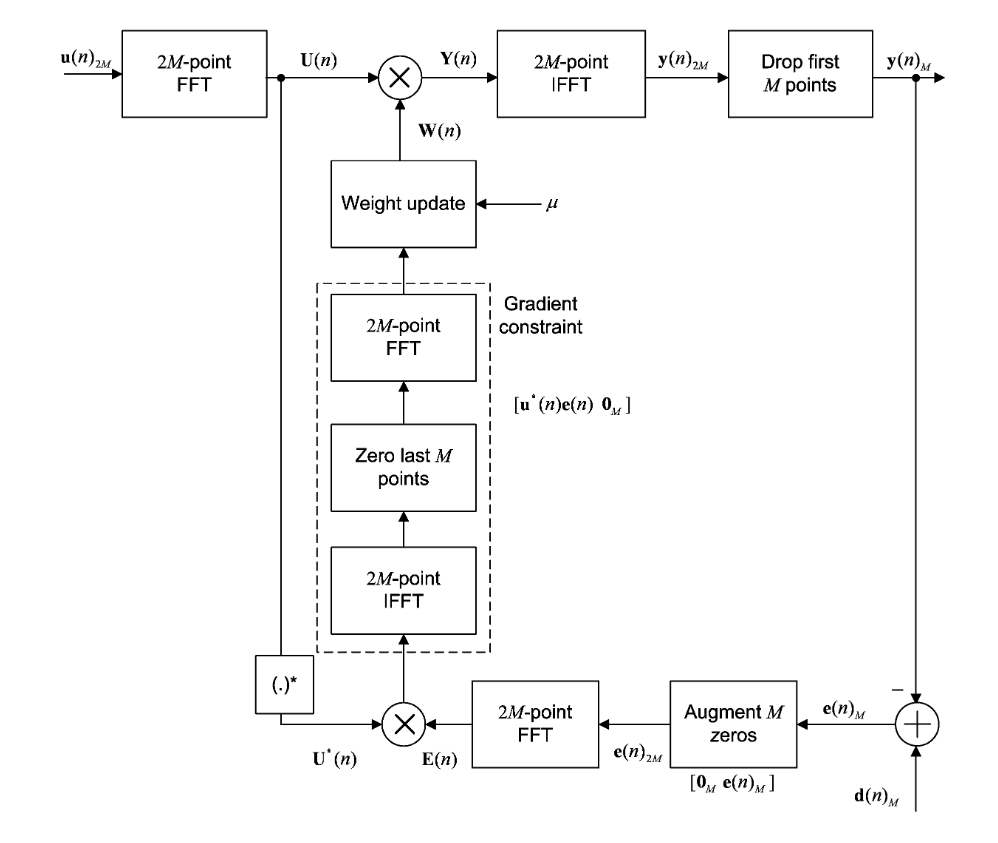

In [1]:
import numpy as np
from tools import generate_bandpass_wn, loading_paths_from_MAT
from plot_tools import WaveVisualizer
from scipy.signal import lfilter,lfilter_zi
from scipy.fft import fft,ifft

In [2]:
## Initialize the parameters
# Length of the filter
M = 256
# Learning rate
muw = 0.005
# Sample rate
fs = 48000
# Simulation time
t = 50
# Total length of the input data
N = fs * t

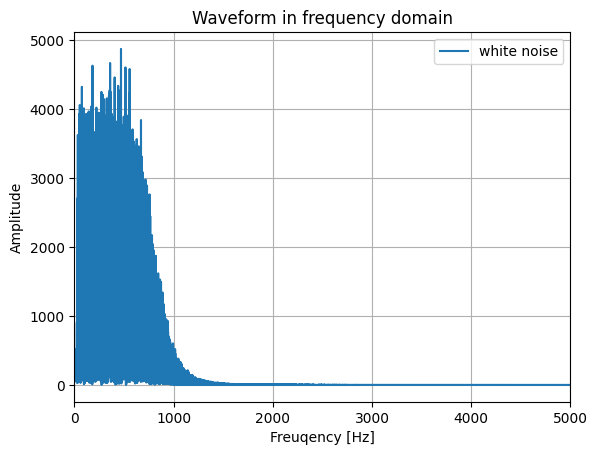

In [3]:
# Generate the white noise which has frequency components in [30Hz,800Hz]
x_wn = generate_bandpass_wn(N, fs, 30, 800)
Plot_wn = WaveVisualizer(x_wn, fs, 'white noise')
Plot_wn.plot_frequency_domain()

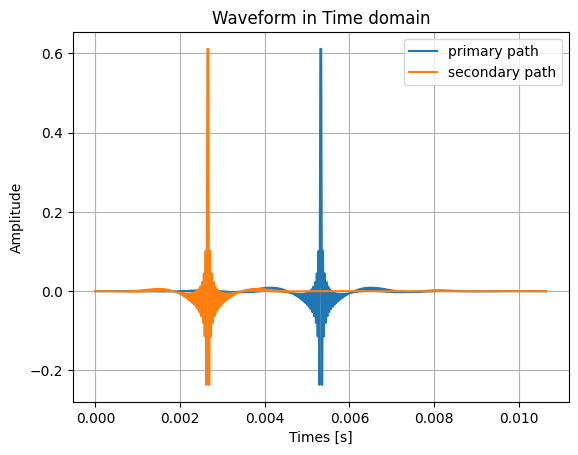

In [4]:
# Load the impulse response of primary path and secondary path
pri_path, sec_path = loading_paths_from_MAT()
sec_path = np.concatenate([sec_path, np.zeros(M)])
Plot_pri = WaveVisualizer(pri_path, fs, 'primary path')
Plot_sec = WaveVisualizer(sec_path, fs, "secondary path")
Plot_pri.plot_time_domain()
Plot_sec.plot_time_domain()


In [5]:
## Initialize the variables
# Initialize the vector of padding zeros
pad_M_zeros = np.zeros(M)
# Disturbance signal received by error microphone
dis_signal = lfilter(pri_path, 1, x_wn)
dis_matrix = np.zeros((N//M,M))
# Reference signal received by reference microphone
ref_signal = x_wn
ref_signal = np.concatenate([pad_M_zeros, ref_signal])
# print(ref_signal)
# Initialize the error signal
error = np.zeros(N)
error_block = np.zeros(M)
error_block_pad = np.zeros(2*M)
error_block_FD = np.zeros(2*M)
# Initialize the block of reference signal
ref_block = np.zeros(2*M)
ref_block_FD = np.zeros(2*M)
# Initialize the output
y = np.zeros(N)
y_block = np.zeros(M)
y_block_FD = np.zeros(2*M)
# Initialize the weight
w_block = np.zeros(M)
w_block_FD = np.zeros(2*M)
# Initialize the temporary variables
temp1 = np.zeros(2*M)
temp2 = np.zeros(2*M)
temp3 = np.zeros(2*M)
# Initialize the gradient
gradient_FD = np.zeros(2*M)
# Initialize the filter
zf = np.zeros(2*M-1)

In [6]:
## FDAF FxLMS
# Chunking the reference signal
for i in range(N//M):
    for j in range(M):
        dis_matrix[i,j] = dis_signal[j+i*M]

for i in range(N//M):
    ref_block = ref_signal[i*M:(i+1)*M+M]
    ref_block_FD = fft(ref_block, 2*M)
    ref_block_FD_s = fft(sec_path, 2*M) * ref_block_FD
    ref_block_FD_s_conj = np.conj(ref_block_FD_s)
    y_block_FD = w_block_FD * ref_block_FD
    y_block = np.real(ifft(y_block_FD, 2*M))
    y_block = y_block[M:]
    [f_y_block , zf] = lfilter(sec_path, 1, y_block, zi=zf)
    error_block = dis_matrix[i,:] - f_y_block
    error_block_pad = np.concatenate((pad_M_zeros, error_block))
    error_block_FD = fft(error_block_pad,2*M)
    error[i*M:i*M+M] = error_block
    temp1 = ref_block_FD_s_conj * error_block_FD
    temp2 = np.real(ifft(temp1, 2*M))
    temp3 = np.concatenate((temp2[:M], pad_M_zeros))
    gradient_FD = fft(temp3, 2*M)
    w_block_FD = w_block_FD + muw * gradient_FD


The SPL is 70.42 dB
The SPL is 33.55 dB


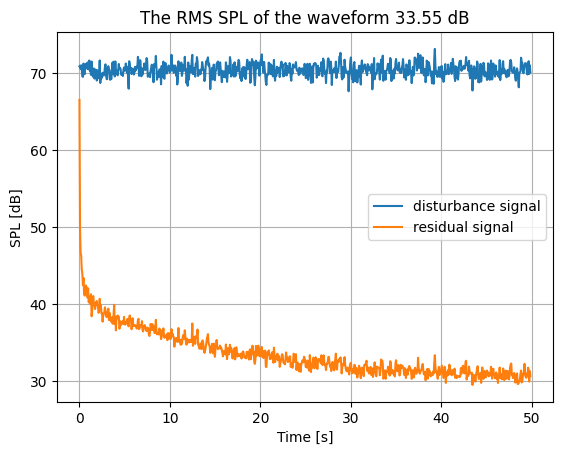

In [7]:
Plot_dis = WaveVisualizer(dis_signal, fs,'disturbance signal')
Plot_error = WaveVisualizer(error, fs,'residual signal')
Plot_dis.plot_RMS_SPL()
Plot_error.plot_RMS_SPL()


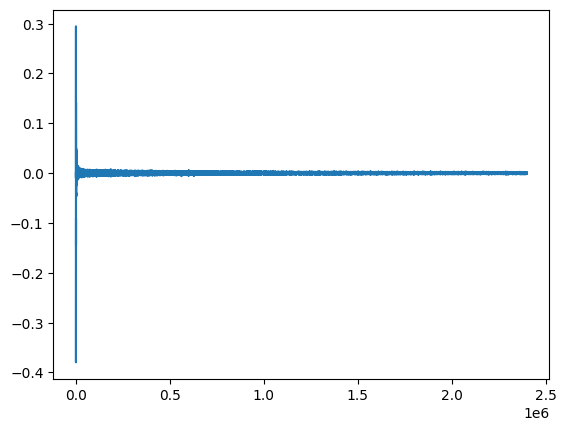

In [8]:
import matplotlib.pyplot as plt
plt.plot(error)